In [1]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("vinayshanbhag/bird-song-data-set")

print("Path to dataset files:", path)

# move path to current folder
shutil.move(path, ".")


# Download latest version
path = kagglehub.dataset_download("wenewone/cub2002011")

print("Path to dataset files:", path)

# move path to current folder
shutil.move(path, ".")

/Users/shanaywadhwani/Desktop/CV/mini-project-2-team-3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.09G/2.09G [04:04<00:00, 9.17MB/s]

Extracting files...


Path to dataset files: /Users/shanaywadhwani/.cache/kagglehub/datasets/vinayshanbhag/bird-song-data-set/versions/1


100%|██████████| 1.49G/1.49G [02:48<00:00, 9.51MB/s]

Extracting files...


Path to dataset files: /Users/shanaywadhwani/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7


'./7'

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm


Bad value in file PosixPath('/Users/shanaywadhwani/.matplotlib/stylelib/my_style1.mplstyle'), line 1 ('figure.facecolor : #EEECF2'): Key figure.facecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/shanaywadhwani/.matplotlib/stylelib/my_style1.mplstyle'), line 19 ('axes.facecolor : #F0F2EC'): Key axes.facecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/shanaywadhwani/.matplotlib/stylelib/my_style1.mplstyle'), line 20 ('axes.edgecolor : #b0a6c2'): Key axes.edgecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/shanaywadhwani/.matplotlib/stylelib/my_style1.mplstyle'), line 31 ('legend.facecolor : #EEECF2'): Key legend.facecolor: '' does not look like a color arg


In [3]:
def audio_to_spectrogram(audio_path, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)  # Load audio with a smaller sample rate
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)  # Convert to dB
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    spectrogram_path = audio_path.replace('.wav', '_spectrogram.png')
    plt.savefig(spectrogram_path)  # Save spectrogram as an image
    plt.close()
    return spectrogram_path

def process_all_audio_files(audio_directory, batch_size=10):
    # List all .wav files in the directory
    wav_files = [f for f in os.listdir(audio_directory) if f.endswith('.wav')]

    # Process files in batches with a progress bar
    spectrogram_paths = []
    for i in tqdm(range(0, len(wav_files), batch_size), desc="Processing Batches"):
        batch_files = wav_files[i:i + batch_size]
        for wav_file in batch_files:
            audio_path = os.path.join(audio_directory, wav_file)
            spectrogram_path = audio_path.replace('.wav', '_spectrogram.png')
            
            # Check if the spectrogram already exists
            if not os.path.exists(spectrogram_path):
                spectrogram_path = audio_to_spectrogram(audio_path)
                spectrogram_paths.append(spectrogram_path)

    return spectrogram_paths

audio_directory = './1/wavfiles/'
spectrograms = process_all_audio_files(audio_directory)

Processing Batches: 100%|██████████| 911/911 [04:51<00:00,  3.12it/s] 


In [ ]:
import pandas as pd
import os

# Load your metadata CSV file into a DataFrame
metadata_path = './1/bird_songs_metadata.csv'
df = pd.read_csv(metadata_path)

# Assuming your spectrogram images are saved in a directory, e.g., './spectrograms/'
spectrogram_dir = './1/wavfiles/'

# Create a dictionary to map filenames to species names
file_to_label = dict(zip(df['filename'].str.replace('.wav', ''), df['name']))

# List spectrogram files (you may need to adjust this based on your actual file names and extensions)
spectrogram_files = [f for f in os.listdir(spectrogram_dir) if f.endswith('.png')]

# Map each spectrogram to the corresponding label
spectrogram_label_pairs = []

for spectrogram_file in spectrogram_files:
    # Get the base filename before the '_spectrogram.png'
    base_filename = os.path.basename(spectrogram_file).replace('_spectrogram.png', '')

    
    # Get the corresponding label from the metadata
    if base_filename in file_to_label:
        label = file_to_label[base_filename]
        spectrogram_label_pairs.append((os.path.join(spectrogram_dir, spectrogram_file), label))


print(spectrogram_label_pairs[:5])

[('./1/wavfiles/351075-6_spectrogram.png', "Bewick's Wren"), ('./1/wavfiles/561356-8_spectrogram.png', 'Song Sparrow'), ('./1/wavfiles/499260-6_spectrogram.png', 'Northern Mockingbird'), ('./1/wavfiles/451371-1_spectrogram.png', "Bewick's Wren"), ('./1/wavfiles/321894-5_spectrogram.png', 'Northern Mockingbird')]


In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Initialize lists to store images and labels
images = []
labels = []

# Loop through the spectrogram-label pairs and prepare the data
for spectrogram_path, label in spectrogram_label_pairs:
    # Load and preprocess the image (resize and normalize)
    image = load_img(spectrogram_path, target_size=(224, 224))  # Resize to match model input size
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    images.append(image)
    labels.append(label)

# Convert images and labels to arrays
X = np.array(images)
y = np.array(labels)

# You might want to encode the labels if you're doing classification (e.g., one-hot encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Converts labels to integer labels
y_encoded = np.expand_dims(y_encoded, axis=-1)  # Adjust shape for the model

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Example: check the shape of the training data
print(X_train.shape, y_train.shape)

(4337, 224, 224, 3) (4337, 1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.5773 - loss: 1.1774 - val_accuracy: 0.2083 - val_loss: 1.6216
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.8200 - loss: 0.4729 - val_accuracy: 0.1760 - val_loss: 9.6274
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.8852 - loss: 0.3339 - val_accuracy: 0.1760 - val_loss: 1.6252
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.9023 - loss: 0.2767 - val_accuracy: 0.1760 - val_loss: 2.5672
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.9288 - loss: 0.2158 - val_accuracy: 0.2424 - val_loss: 1.8499
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.9522 - loss: 0.1542 - val_accuracy: 0.6018 - val_loss: 0.9272
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.9672 - loss: 0.1046 - val_accuracy: 0.8525 - val_loss: 0.4226
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 481s 

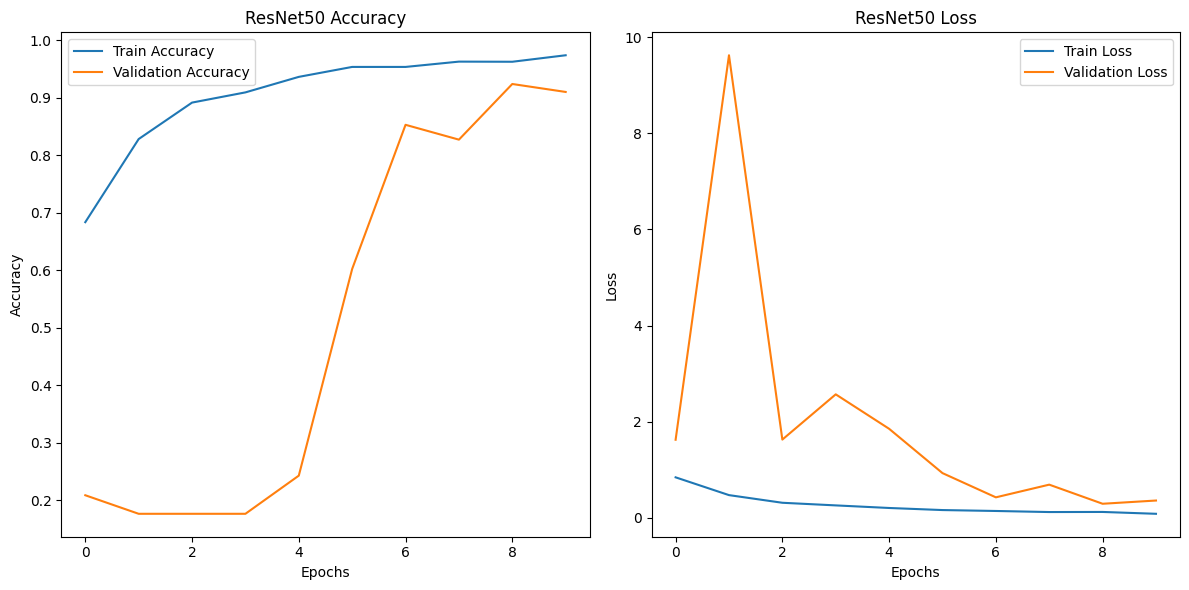

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step
ResNet50 Inference Time (per sample): 0.0317 seconds
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1098s 8s/step - accuracy: 0.2169 - loss: 2.5757 - val_accuracy: 0.2212 - val_loss: 1.6064
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1097s 8s/step - accuracy: 0.2333 - loss: 1.6033 - val_accuracy: 0.2212 - val_loss: 1.6062
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1062s 8s/step - accuracy: 0.2305 - loss: 1.6038 - val_accuracy: 0.2212 - val_loss: 1.6064
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1096s 8s/step - accuracy: 0.2297 - loss: 1.6025 - val_accuracy: 0.2212 - val_loss: 1.6060
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1089s 8s/step - accuracy: 0.2263 - loss: 1.6046 - val_accuracy: 0.2212 - val_loss: 1.6061
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1037s 8s/step - accuracy: 0.2348 - loss: 1.6014 - val_accuracy: 0.2212 - val_loss: 1.6067
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1057s 8s/step - accuracy: 0.2369 - lo

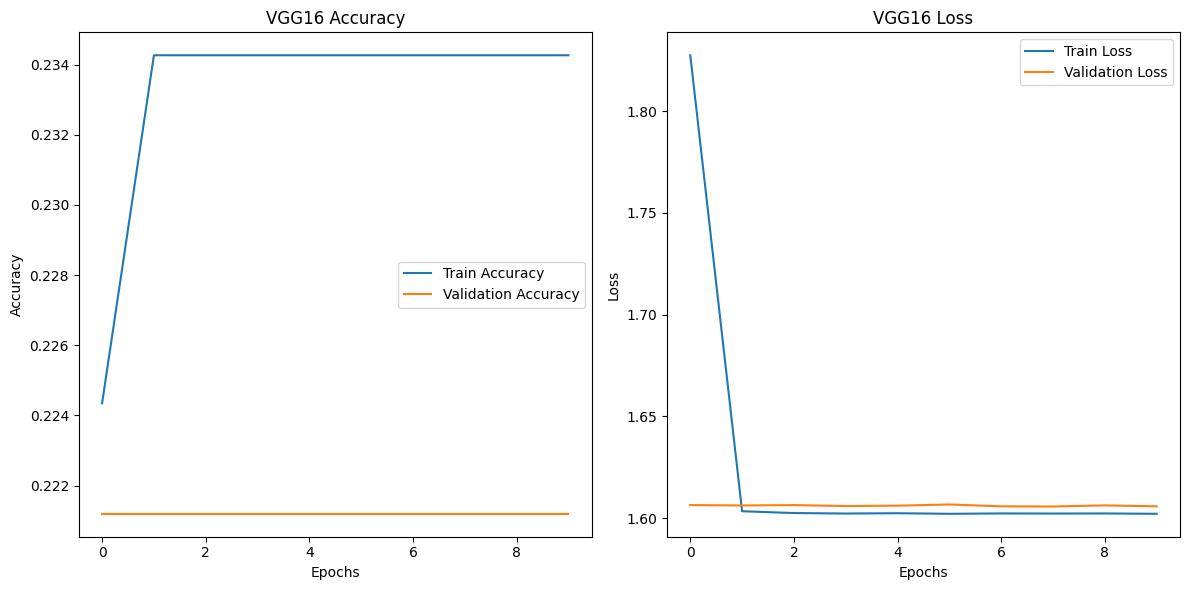

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
VGG16 Inference Time (per sample): 0.0711 seconds


In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Assuming X_train, X_val, y_train, and y_val are already prepared

# Function to plot performance metrics
def plot_metrics(history, model_name):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to evaluate inference time
def evaluate_inference_time(model, X_test, num_samples=100):
    start_time = time.time()
    model.predict(X_test[:num_samples])  # Predict for a small sample
    end_time = time.time()
    inference_time = (end_time - start_time) / num_samples  # Average time per sample
    return inference_time

# --- ResNet50 Model ---
resnet_model = tf.keras.Sequential([
    tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(['name'].unique()), activation='softmax')
])

resnet_model.compile(optimizdfer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model
resnet_history = resnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Plot the ResNet50 performance metrics
plot_metrics(resnet_history, "ResNet50")

# Evaluate inference time for ResNet50
resnet_inference_time = evaluate_inference_time(resnet_model, X_val)
print(f"ResNet50 Inference Time (per sample): {resnet_inference_time:.4f} seconds")

# --- VGG16 Model ---
vgg_model = tf.keras.Sequential([
    tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(df['name'].unique()), activation='softmax')
])

vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model
vgg_history = vgg_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Plot the VGG16 performance metrics
plot_metrics(vgg_history, "VGG16")

# Evaluate inference time for VGG16
vgg_inference_time = evaluate_inference_time(vgg_model, X_val)
print(f"VGG16 Inferep[\nce Time (per sample): {vgg_inference_time:.4f} seconds")

In [16]:
resnet_model.save('resnet50_bird_classifier.h5') 

In [17]:
vgg_model.save('vgg16_bird_classifier.h5') 